4장에서는 텍스트를 분석해서 첫 ***텍스트를 분류***하는 문제를 실습했고, 5장에서는 두 개의 텍스트가 있을 때 각 ***텍스트끼리의 유사도***를 판단하는 문제를 실습했다. 이번 장에서는 텍스트를 단순히 분석해서 분류나 유사도를 측정하는 것이 아닌 직접 문장을 생성할 수 있는 ***텍스트 생성(text Generation)***

일반적으로 챗봇을 제작하는 방법은 매우 다양하다.
- 단순하게 규칙 기반
- 머신러닝을 활용한 유사도 기반
- 규칙과 머신러닝을 섞은 하이브리드 기반
- 특정 시나리오에서 동작이 가능해지는 시나리오 기반까지 정의하는 사람에 따라 제작 방법이 매우 다양하다.
- 시퀀스 투 시퀀스(Sequence to sequence)모델을 활용해 챗봇을 제작하는 법을 알아보고자 한다.

# 01. 데이터 소개

|데이터 이름|Chatbot data|
|:--:|:--:|
|데이터 용도|한국어 챗봇 학습을 목적으로 사용한다.|
|데이터 권한|MIT 라이선스|
|데이터 출처|https://github.com/songys/Chatbot_data|

# 02. 데이터 분석

In [1]:
import pandas as pd

DATA_IN_PATH = './data_in/'
data = pd.read_csv(DATA_IN_PATH + './ChatBotData.csv', encoding='utf-8', delimiter=',')

data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


### 2-1. 문장 전체에 대한 분석

먼저 데이터의 길이를 분석한다. 질문과 답변 모두에 대해 길이를 분석하기 위해 두 데이터를 하나의 리스트로 만들자.

In [2]:
sentences = list(data['Q'] + list(data['A']))

분석 기준은 다음과 같다.
- 문자 단위의 길이 분석(음절)
- 단어 단위의 길이 분석(어절)
- 형태소 단위의 길이 분석

In [3]:
tokenized_sentences = [s.split() for s in sentences]
sent_len_by_token = [len(t) for t in tokenized_sentences]
sent_len_by_eumjeol = [len(s.replace(' ','')) for s in sentences]

from konlpy.tag import Okt

okt = Okt()

morph_tokenized_sentences = [okt.morphs(s.replace(' ', '')) for s in sentences]
sent_len_by_morph = [len(t) for t in morph_tokenized_sentences]

우선 띄어쓰기 기준으로 문장을 나눈다. 이 값의 길이를 측정해서 어절의 길이를 측정하고 이 값을 다시 붙여서 길이를 측정해서 음절의 길이로 사용한다. 마지막으로 형태소를 나누기 위해 KoNLPY에 Okt 형태소 분석기를 사용해서 나눈 후 길이를 측정한다.

맷플롯립을 활용해 각각에 대한 그래프를 그려보자


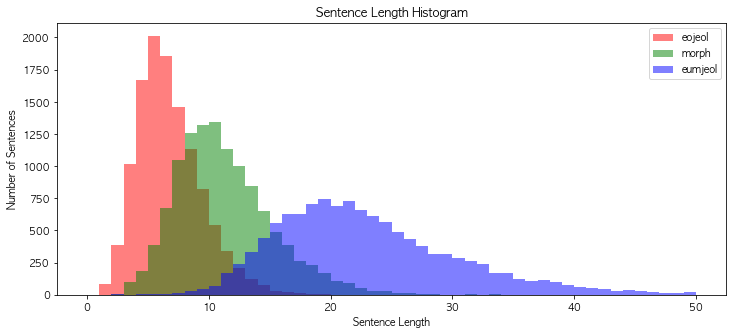

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.hist(sent_len_by_token, bins=50, range=[0,50], alpha=0.5, 
        color='r', label='eojeol')

plt.hist(sent_len_by_morph, bins=50, range=[0,50], alpha=0.5,
       color='g', label='morph')
plt.hist(sent_len_by_eumjeol, bins=50, range=[0,50], alpha=0.5,
        color='b', label='eumjeol')

plt.title('Sentence Length Histogram')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')

plt.legend()
plt.show()

- 빨간색: 어절 단위
- 초록색: 형태소 단위
- 파란색: 음절 단위

히스토그램을 통해 각 길이가 어느 쪽으로 치우쳐 있는지 혹은 각 데이터에 이상치는 없는지 등도 확인할 수 있는데 이 히스토그램을 통해서는 직관적으로 확인이 어렵다.

이는 각 히스토그램의 y값 분포가 매우 다르기 때문이다. y값의 크기를 조정함으로써 이를 해결할 수 있다.

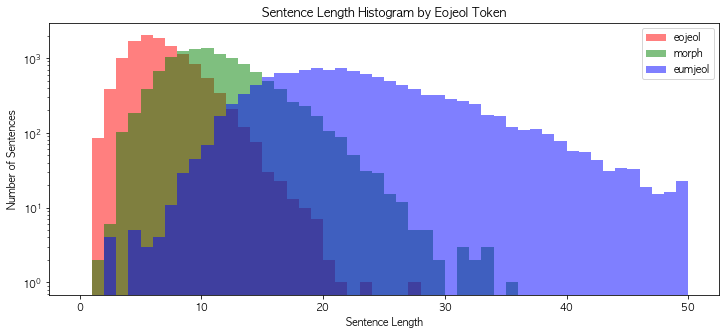

In [5]:
plt.figure(figsize=(12,5))
plt.hist(sent_len_by_token, bins=50, range=[0,50], alpha=0.5, 
        color = 'r', label = 'eojeol')
plt.hist(sent_len_by_morph, bins=50, range=[0,50], alpha=0.5,
        color = 'g', label = 'morph')
plt.hist(sent_len_by_eumjeol, bins=50, range=[0,50], alpha=0.5,
        color = 'b', label = 'eumjeol')

plt.yscale('log')
plt.title('Sentence Length Histogram by Eojeol Token')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')

plt.legend()
plt.show()

이전 코드와 달라진 점은 중간에ㅐ yscale 함수를 사용했다는 점입니다. 함수의 인자로 사용된 'log'는 각 그래프가 가지는 y값의 스케일을 조정함으로써 차이가 큰 데이터에 대해서도 함께 비교할 수 있게 한다.

이제 각 길이값을 히스토그램이 아닌 정확한 수치를 확인하기 위해 각 기준별 길이에 대한 여러 가지 통곗값을 확인해 보자. 우선 어절에 대해 각 통곗값을 출력해보자

In [6]:
import numpy as np

print('어절 최대 길이: {}'.format(np.max(sent_len_by_token)))
print('어절 최소 길이: {}'.format(np.min(sent_len_by_token)))
print('어절 평균 길이: {:.2f}'.format(np.mean(sent_len_by_token)))
print('어절 길이 표준편차: {:.2f}'.format(np.std(sent_len_by_token)))
print('어절 중간 길이: {:.2f}'.format(np.median(sent_len_by_token)))
print('제1사분위 길이: {}'.format(np.percentile(sent_len_by_token,25)))
print('제3사분위 길이: {}'.format(np.percentile(sent_len_by_token,75)))


어절 최대 길이: 27
어절 최소 길이: 1
어절 평균 길이: 6.28
어절 길이 표준편차: 2.67
어절 중간 길이: 6.00
제1사분위 길이: 4.0
제3사분위 길이: 8.0


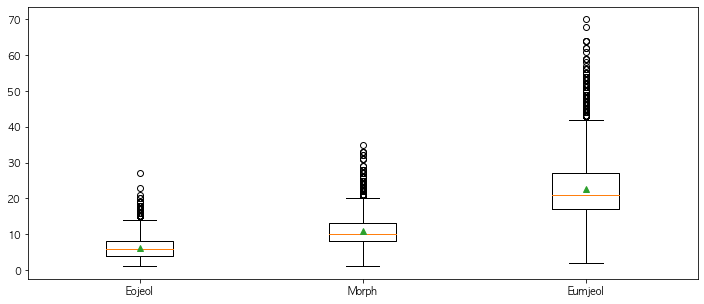

In [7]:
plt.figure(figsize=(12,5))
plt.boxplot([sent_len_by_token, sent_len_by_morph, sent_len_by_eumjeol],
           labels=['Eojeol', 'Morph', 'Eumjeol'],
           showmeans=True)

plt.show()

### 2-2 질문, 답변 각각에 대한 문장 길이 분포 분석

이제 전체 데이터가 아닌 질문과 응답으로 구성된 각 문장에 대한 길이 분포를 따로 알아보자. 여기서는 그 중 형태소 기준으로만 길이를 분석해본다.


In [8]:
query_sentences = list(data['Q'])
answer_sentences = list(data['A'])

query_morph_tokenized_sentences = [okt.morphs(s.replace(' ', '')) for s in query_sentences]
query_sent_by_morph = [len(t) for t in query_morph_tokenized_sentences]

answer_morph_tokenized_sentences = [okt.morphs(s.replace(' ','')) for s in answer_sentences]
answer_sent_len_by_morph = [len(t) for t in answer_morph_tokenized_sentences]


이제 이렇게 형태소로 나눈 길이를 히스토그램으로 그려보자. 질문과 답변에 대한 길이를 한 번에 히스토그램으로 그린다.

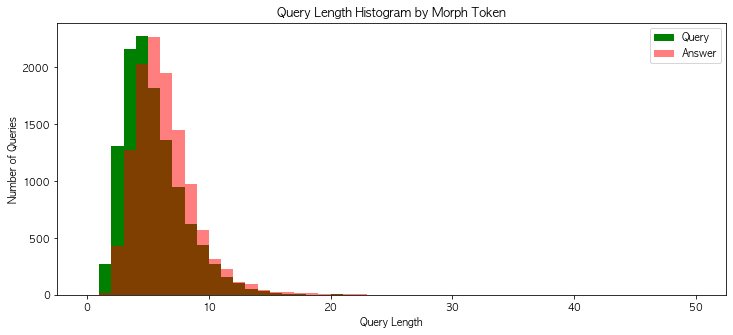

In [9]:
plt.figure(figsize=(12,5))
plt.hist(query_sent_by_morph, bins=50, range=[0,50], color='g', label='Query')
plt.hist(answer_sent_len_by_morph, bins=50, range=[0,50], color='r', alpha=0.5, label='Answer')
plt.legend()
plt.title('Query Length Histogram by Morph Token')
plt.xlabel('Query Length')
plt.ylabel('Number of Queries')
plt.show()

/Users/keemyohaan/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """


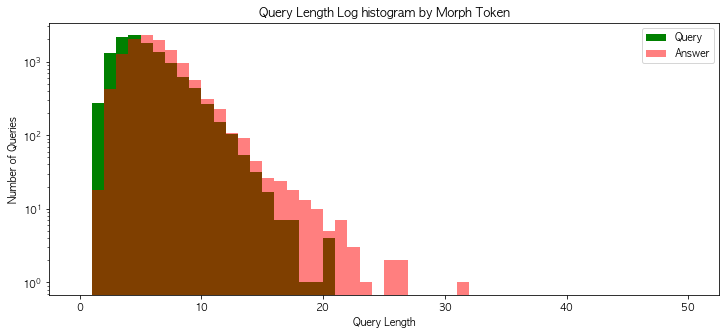

In [10]:
plt.figure(figsize=(12,5))
plt.hist(query_sent_by_morph, bins=50, range=[0,50], color='g', label='Query')
plt.hist(answer_sent_len_by_morph, bins=50, range=[0,50], color='r', alpha=0.5, label='Answer')
plt.legend()
plt.yscale('log', nonposy='clip')
plt.title('Query Length Log histogram by Morph Token')
plt.xlabel('Query Length')
plt.ylabel('Number of Queries')
plt.show()

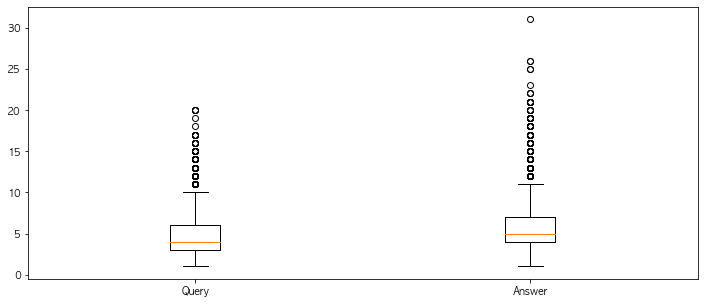

In [11]:
plt.figure(figsize=(12,5))
plt.boxplot([query_sent_by_morph, answer_sent_len_by_morph],
           labels=['Query', 'Answer'])
plt.show()

### 2-3. 데이터 어휘 빈도 분석

In [12]:
okt.pos('오늘밤은유난히덥구나')

[('오늘밤', 'Noun'), ('은', 'Josa'), ('유난히', 'Adverb'), ('덥구나', 'Adjective')]

In [13]:
query_NVA_token_sentences = list()
answer_NVA_token_sentences = list()

for s in query_sentences:
    for token, tag in okt.pos(s.replace(' ','')):
        if tag == 'Noun' or tag == 'Verb' or tag == 'Adjective':
            query_NVA_token_sentences.append(token)
            
for s in answer_sentences:
    temp_token_bucket = list()
    for token, tag in okt.pos(s.replace(' ','')):
        if tag == 'Noun' or tag == 'Verb' or tag == 'Adjective':
            answer_NVA_token_sentences.append(token)
            
query_NVA_token_sentences =' '.join(query_NVA_token_sentences)
answer_NVA_token_sentences = ' '.join(answer_NVA_token_sentences)

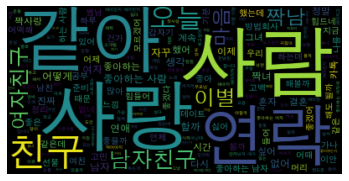

In [16]:
from wordcloud import WordCloud

query_wordcloud = WordCloud(font_path=DATA_IN_PATH + '/System/Library/Fonts/Supplemental/AppleGothic.ttf').generate(query_NVA_token_sentences)

plt.imshow(query_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

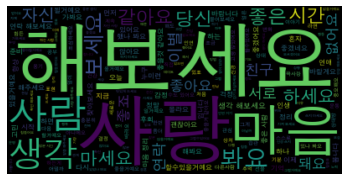

In [17]:
# 답변 데이터에 대해서도 동일하게 워드클라우드를 그려서 살펴보자
answer_wordcloud = WordCloud(font_path=DATA_IN_PATH + '/System/Library/Fonts/Supplemental/AppleGothic.ttf').generate(answer_NVA_token_sentences)

plt.imshow(answer_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
